In [93]:
import pydpmd as dp
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
import os
from tqdm import tqdm

In [159]:
root = '/home/mmccraw/dev/data/11-06-25/dynamics/N-100'

nv = []
mu = []
delta_phis = []
sids = []
C_vs = []
C_v_var_pes = []
C_v_lpvs = []

for ptype in tqdm(os.listdir(root)):
    _nv, _mu = ptype.split('-')
    _nv = int(_nv)
    _mu = float(_mu)

    path = os.path.join(root, ptype, 'jamming_2')
    data = dp.data.load(path, location=['final', 'init'], load_trajectory=True, load_full=True)
    data.calculate_mu_eff()

    N = data.system_size.copy() - 1
    d = 3
    dsid = data.original_system_id.copy()
    target_temp = data.target_temp.copy()
    delta_phi = data.delta_phi.copy()

    t0 = 500
    tf = -1

    ke = data.trajectory.ke_total.copy()[t0:tf]
    pe = data.trajectory.pe_total.copy()[t0:tf]
    te = ke + pe
    temp = 2 * np.mean(ke, axis=0) / (N * d)

    C_v_var_pe = N * d / 2 + np.var(pe, axis=0) / temp ** 2
    C_v_lpv = N * d / 2 * (1 - N * d / 2 * np.var(ke, axis=0) / np.mean(ke, axis=0) ** 2) ** -1

    mean_te = np.mean(te, axis=0)

    for _dsid in np.unique(dsid):
        for _delta_phi in np.unique(delta_phi):
            mask = (dsid == _dsid) & (delta_phi == _delta_phi)
            # T = target_temp[mask]
            T = temp[mask]
            TE = mean_te[mask]
            C_v, _ = np.polyfit(T, TE, 1)
            
            delta_phis.append(-_delta_phi)
            sids.append(_dsid)
            C_vs.append(C_v / N[mask][0])
            C_v_var_pes.append(np.mean(C_v_var_pe[mask]) / N[mask][0])
            C_v_lpvs.append(np.mean(C_v_lpv[mask]) / N[mask][0])
            nv.append(_nv)
            mu.append(data.mu_eff[0])

df = pd.DataFrame({
    'nv': nv,
    'mu': mu,
    'delta_phi': delta_phis,
    'sid': sids,
    'C_v': C_vs,
    'C_v_var_pe': C_v_var_pes,
    'C_v_lpv': C_v_lpvs
})

100%|██████████| 30/30 [00:04<00:00,  6.35it/s]


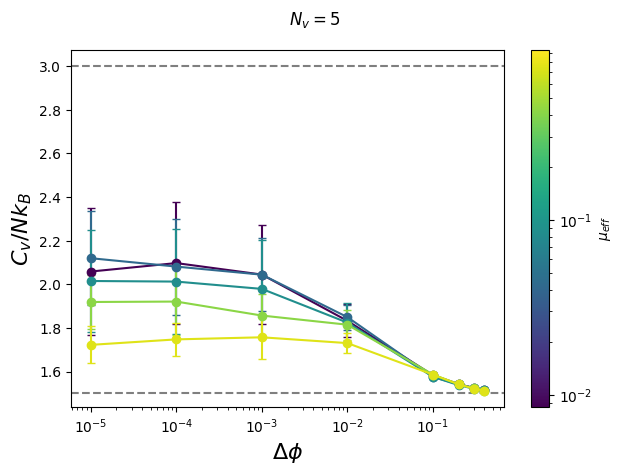

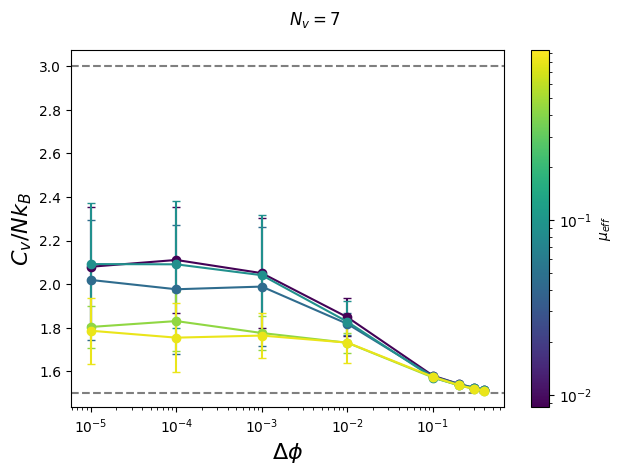

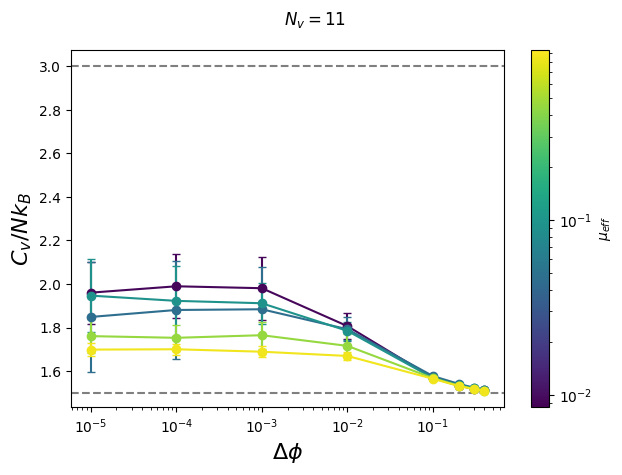

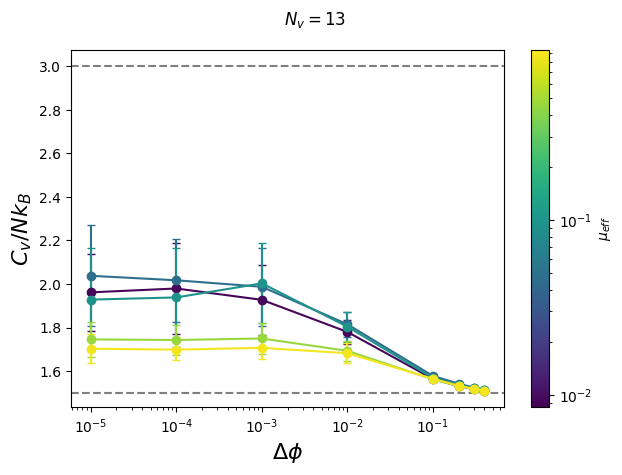

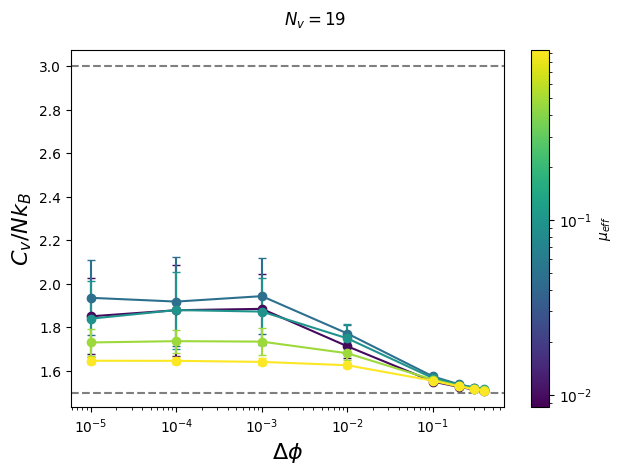

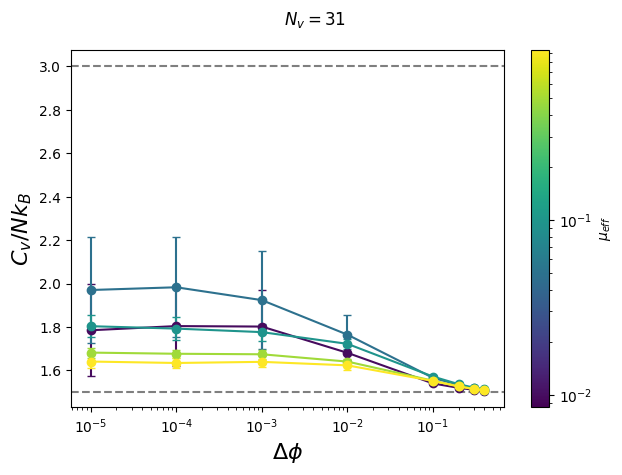

In [161]:
mu_norm = LogNorm(vmin=np.min(df.mu), vmax=np.max(df.mu))
cmap = plt.cm.viridis

for nv in np.unique(df.nv):
    for mu in np.unique(df.mu):
        mask = (df.nv == nv) & (df.mu == mu)
        if not np.any(mask):
            continue

        delta_phi = []
        C_v = []
        for sid in np.unique(df[mask].sid):
            _df = df[mask & (df.sid == sid)]
            delta_phi.append(_df.delta_phi)
            C_v.append(_df.C_v)

        delta_phi = np.mean(delta_phi, axis=0)
        C_v_error = np.std(C_v, axis=0)
        C_v = np.mean(C_v, axis=0)

        plt.errorbar(delta_phi, C_v, yerr=C_v_error, c=cmap(mu_norm(mu)), marker='o', capsize=3)
    plt.xscale('log')
    sm = plt.cm.ScalarMappable(norm=mu_norm, cmap=cmap)
    sm.set_array(df.mu)
    cbar = plt.colorbar(sm, ax=plt.gca(), label=r'$\mu_{eff}$')
    plt.xlabel(r'$\Delta \phi$', fontsize=16)
    plt.ylabel(r'$C_v / N k_B$', fontsize=16)
    plt.axhline(d, zorder=0, linestyle='--', c='k', alpha=0.5)
    plt.axhline(d / 2, zorder=0, linestyle='--', c='k', alpha=0.5)
    plt.suptitle(fr'$N_v=${nv}')
    plt.tight_layout()
    plt.savefig(f'figures/heat-capacity-rb-final/NV-{nv}.png', dpi=600)
    plt.show()